# Making A Synth - Modulators

In [1]:
import librosa
import numpy as np
import seaborn as sns
from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt

In [207]:
# required imports
import math
import itertools
from synth.components import SineOscillator, SquareOscillator, SawtoothOscillator, TriangleOscillator

###### Constants and inits

In [3]:
# Constants and inits
sns.set_theme()
SR = 44_100

figsize=(25, 6.25)
colors = "#323031", "#308E91", "#34369D","#5E2A7E", "#5E2A7E", "#6F3384"

###### Helper Functions

In [4]:
hz = lambda note:librosa.note_to_hz(note)
getfig = lambda : plt.figure(figsize=figsize)
savefig = lambda fig, name: fig.savefig(f"./tempimg/{name}.jpg")
to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))

def plot(xy, r=1,c=1,i=1,title="", xlabel="",ylabel="",yticks=None, xticks=None,**plot_kwargs):
    # plt.plot helper
    if r > 0:
        plt.subplot(r,c,i)
    plt.title(title)
    if len(xy) == 2:
        plt.plot(*xy, **plot_kwargs)
    else:
        plt.plot(xy, **plot_kwargs)
        
    if xticks is not None: plt.xticks(xticks)
    if yticks is not None: plt.yticks(yticks)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
def getval(osc, count=SR, it=False):
    if it: osc = iter(osc)
    # returns 1 sec of samples of given osc.
    return [next(osc) for i in range(count)]

def getseq(osc, notes=["C4", "E4", "G4"], note_lens=[0.5,0.5,0.5]):
    # Returns samples of the note seq for the given osc.
    samples = []
    osc = iter(osc)
    for note, note_len in zip(notes, note_lens):
        osc.freq = librosa.note_to_hz(note)
        for _ in range(int(SR * note_len)):
            samples.append(next(osc))
    return samples

def wave_to_file(wav, wav2=None, fname="temp", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(f"tempsnd/{fname}.wav", SR, wav)
    
def fplot_xy(wave, fslice=slice(0,100), sample_rate=SR):
    # Returns FFTed samples of input wave
    fd = np.fft.fft(wave)
    fd_mag = np.abs(fd)
    x = np.linspace(0, sample_rate, len(wave))
    y = fd_mag * 2 / sample_rate
    return x[fslice], y[fslice]

## Envelopes

In [5]:
attack_duration = 0.05
decay_duration = 0.2
sustain_duration = 0.45
release_duration = 0.3

sustain_level = 0.7

attack_len = int(SR * attack_duration)
decay_len = int(SR * decay_duration)
sustain_len = int(SR * sustain_duration)
release_len = int(SR * release_duration)

In [6]:
attack = np.linspace(0,1,attack_len)
decay = np.linspace(1,sustain_level,decay_len)
sustain = np.full((sustain_len, ), sustain_level)
release = np.linspace(sustain_level, 0, release_len)

In [7]:
xa = np.arange(0,attack_len)
xd = np.arange(attack_len, attack_len + decay_len)
xs = np.arange(attack_len + decay_len, attack_len + decay_len + sustain_len)
xr = np.arange(attack_len + decay_len + sustain_len, attack_len + decay_len + sustain_len + release_len)

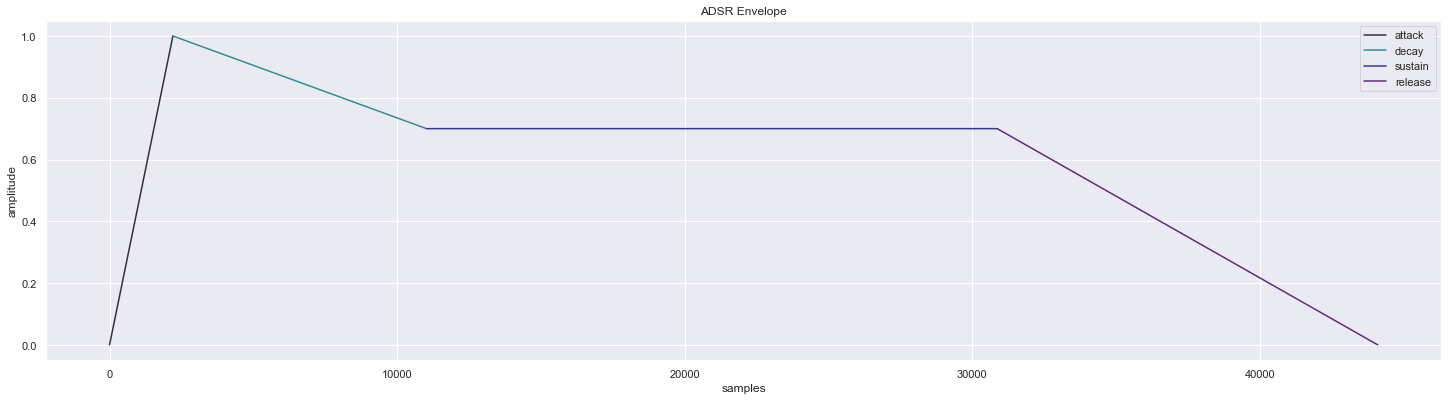

In [8]:
fig = getfig()
plt.title("ADSR Envelope")
plt.plot(xa, attack, color=colors[0], label="attack")
plt.plot(xd, decay, color=colors[1], label="decay")
plt.plot(xs, sustain, color=colors[2], label="sustain")
plt.plot(xr, release, color=colors[3], label="release")
plt.ylabel("amplitude")
plt.xlabel("samples")
plt.legend(loc="upper right")
savefig(fig, "ADSR")

In [9]:
sample_rate = SR

In [10]:
attack_stepper  = itertools.count(0, step =  1 / (attack_duration * sample_rate))
decay_stepper   = itertools.count(1, step = -(1 - sustain_level) / (decay_duration  * sample_rate))
sustain_stepper = itertools.cycle([ sustain_level ])
release_stepper = itertools.count(sustain_level, step = -1 / (release_duration * sample_rate))

In [11]:
def get_ads_stepper(attack_duration, decay_duration, sustain_level, sample_rate=44_100):
    attack_stepper  = itertools.count(start=0, step= 1 / (attack_duration * sample_rate))
    decay_stepper   = itertools.count(1, step = -(1 - sustain_level) / (decay_duration  * sample_rate))
    steppers = [attack_stepper, decay_stepper]
    while True:
        l = len(steppers)
        if l > 0:
            val = next(steppers[0])
            if l == 2 and val > 1:
                steppers.pop(0)
                val = next(steppers[0])
            elif l == 1 and val < sustain_level:
                steppers.pop(0)
                val = sustain_level
        else:
            val = sustain_level
        yield val

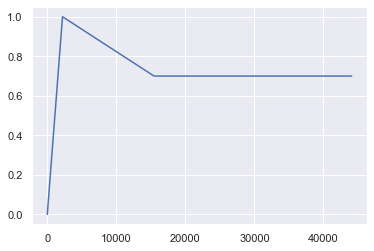

In [12]:
ads_stepper = get_ads_stepper(0.05, 0.3, 0.7)
plot(getval(ads_stepper))

In [13]:
class ADSREnvelope:
    def __init__(self, attack_duration=0.05, decay_duration=0.2, sustain_level=0.7, \
                 release_duration=0.3, sample_rate=SR):
        self.attack_duration = attack_duration
        self.decay_duration = decay_duration
        self.sustain_level = sustain_level
        self.release_duration = release_duration
        self._sample_rate = sample_rate
        
    def get_ads_stepper(self):
        steppers = []
        if self.attack_duration > 0:
            steppers.append(itertools.count(start=0, \
                step= 1 / (self.attack_duration * self._sample_rate)))
        if self.decay_duration > 0:
            steppers.append(itertools.count(start=1, \
            step=-(1 - self.sustain_level) / (self.decay_duration  * self._sample_rate)))
        while True:
            l = len(steppers)
            if l > 0:
                val = next(steppers[0])
                if l == 2 and val > 1:
                    steppers.pop(0)
                    val = next(steppers[0])
                elif l == 1 and val < self.sustain_level:
                    steppers.pop(0)
                    val = self.sustain_level
            else:
                val = self.sustain_level
            yield val
    
    def get_r_stepper(self):
        val = 1
        if self.release_duration > 0:
            release_step = - self.val / (self.release_duration * self._sample_rate)
            stepper = itertools.count(self.val, step=release_step)
        else:
            val = -1
        while True:
            if val <= 0:
                self.ended = True
                val = 0
            else:
                val = next(stepper)
            yield val
    
    def __iter__(self):
        self.val = 0
        self.ended = False
        self.stepper = self.get_ads_stepper()
        return self
    
    def __next__(self):
        self.val = next(self.stepper)
        return self.val
        
    def trigger_release(self):
        self.stepper = self.get_r_stepper()

In [14]:
# adsr_stepper = ADSREnvelope()
# adsr_stepper = iter(adsr_stepper)
# %timeit next(adsr_stepper)
# adsr_stepper.trigger_release()
# %timeit next(adsr_stepper)

# 341 ns ± 8.72 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# 335 ns ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

In [15]:
def getadsr(a=0.05,d=0.3,sl=0.7,r=0.2,sd=0.4, sample_rate=SR):
    adsr = ADSREnvelope(a,d,sl,r)
    down_len = int(sum([a,d,sd])*sample_rate)
    up_len = int(r*sample_rate)
    adsr = iter(adsr)
    adsr_vals = getval(adsr, down_len)
    adsr.trigger_release()
    adsr_vals.extend(getval(adsr, up_len))
    return adsr_vals, down_len, up_len

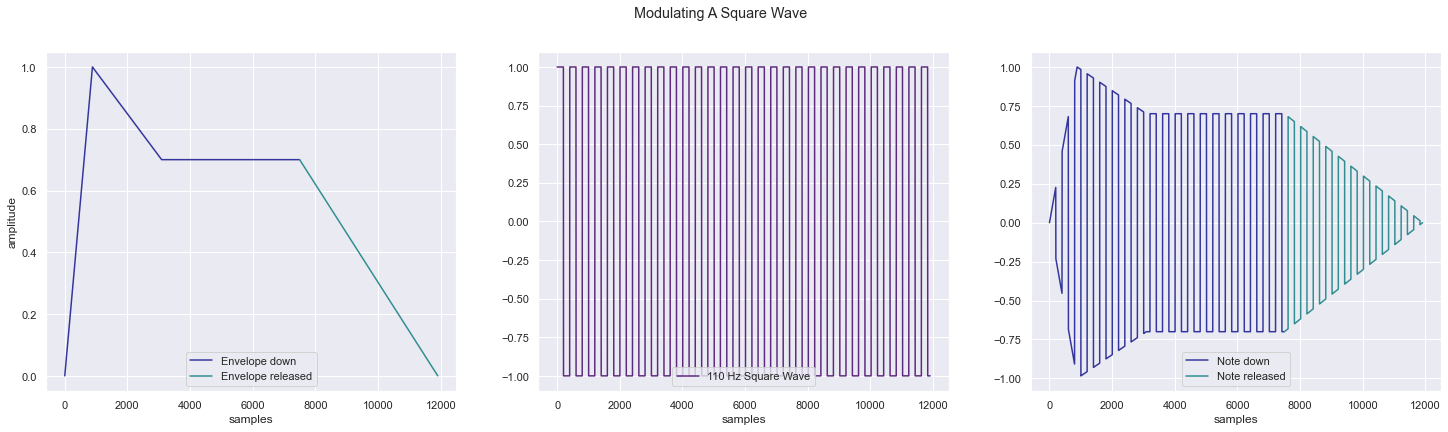

In [16]:
fig = getfig()
fig.suptitle("Modulating A Square Wave")
envvals, down, up = getadsr(0.02,0.05,0.7,0.1,0.1)
envvals = np.array(envvals)
xd = np.arange(down)
xu = np.arange(down, down+up)

plot((xd, envvals[:down]),1,3,1, color=colors[2], label="Envelope down")
plot((xu, envvals[down:]),0,3,1, color=colors[1], label="Envelope released", xlabel="samples", ylabel="amplitude")
plt.legend(loc="lower center")

osc = SquareOscillator(110)
oscvals = np.array(getval(osc, it=True))[:down+up]
plot(oscvals, 1,3,2, label="110 Hz Square Wave", xlabel="samples", color=colors[3])
plt.legend(loc="lower center")

plot((xd, oscvals[:down]*envvals[:down]),1,3,3, color=colors[2], label="Note down")
plot((xu, oscvals[down:]*envvals[down:]),0,3,3, color=colors[1], label="Note released", xlabel="samples")
plt.legend(loc="lower center")
savefig(fig, "adsrsqr")

In [17]:
def amp_mod(init_amp, env):
    return env * init_amp

In [18]:
def freq_mod(init_freq, env, mod_amt=0.01, sustain_level=0.7):
    return init_freq + ((env - sustain_level) * init_freq * mod_amt)

In [19]:
class ModulatedOscillator:
    def __init__(self, oscillator, *modulators, amp_mod=None, freq_mod=None, phase_mod=None):
        self.oscillator = oscillator
        self.modulators = modulators # list
        self.amp_mod = amp_mod
        self.freq_mod = freq_mod
        self.phase_mod = phase_mod
        self._modulators_count = len(modulators)
    
    def __iter__(self):
        iter(self.oscillator)
        [iter(modulator) for modulator in self.modulators]
        return self
    
    def _modulate(self, mod_vals):
        if self.amp_mod is not None:
            new_amp = self.amp_mod(self.oscillator.init_amp, mod_vals[0])
            self.oscillator.amp = new_amp
            
        if self.freq_mod is not None:
            if self._modulators_count == 2:
                mod_val = mod_vals[1]
            else:
                mod_val = mod_vals[0]
            new_freq = self.freq_mod(self.oscillator.init_freq, mod_val)
            self.oscillator.freq = new_freq
            
        if self.phase_mod is not None:
            if self._modulators_count == 3:
                mod_val = mod_vals[2]
            else:
                mod_val = mod_vals[-1]
            new_phase = self.phase_mod(self.oscillator.init_phase, mod_val)
            self.oscillator.phase = new_phase
    
    def trigger_release(self):
        tr = "trigger_release"
        for modulator in self.modulators:
            if hasattr(modulator, tr):
                modulator.trigger_release()
        if hasattr(self.oscillator, tr):
            self.oscillator.trigger_release()
            
    @property
    def ended(self):
        e = "ended"
        ended = []
        for modulator in self.modulators:
            if hasattr(modulator, e):
                ended.append(modulator.ended)
        if hasattr(self.oscillator, e):
            ended.append(self.oscillator.ended)
        return all(ended)

    def __next__(self):
        mod_vals = [next(modulator) for modulator in self.modulators]
        self._modulate(mod_vals)
        return next(self.oscillator)

In [20]:
def getdownlen(env, suslen, sample_rate=SR):
    n = sum(env.attack_duration, env.release_duration, suslen)
    return int(n * sample_rate)

In [21]:
def gettrig(gen, downtime, sample_rate=SR):
    gen = iter(gen)
    down = int(downtime * sample_rate)
    vals = getval(gen, down)
    gen.trigger_release()
    while not gen.ended:
        vals.append(next(gen))
    return vals

In [22]:
def getadsr(a, d, sl, sd, r, Osc=SquareOscillator(55), mod = None):
    if mod is None:
        mod = ModulatedOscillator(
            Osc,
            ADSREnvelope(a,d,sl,r),
            amp_mod=amp_mod
        )
    downtime = a + d + sd
    return gettrig(mod, downtime)

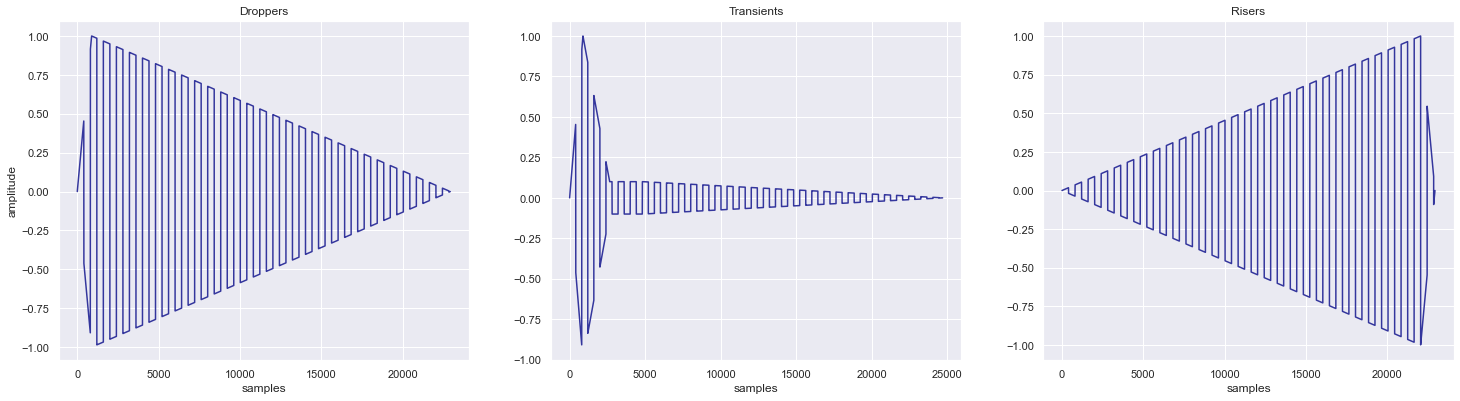

In [23]:
fig = getfig()
vals = getadsr(0.02, 0.5, 0, 0, 0)
plot(vals,1,3,1, title="Droppers", xlabel="samples", ylabel="amplitude", color=colors[2])

vals = getadsr(0.02, 0.04, 0.1, 0.05, 0.45)
plot(vals,1,3,2, title="Transients", xlabel="samples", color=colors[2])

vals = getadsr(0.5, 0.02, 0, 0, 0)
plot(vals,1,3,3, title="Risers", xlabel="samples", color=colors[2])
savefig(fig, "examples")

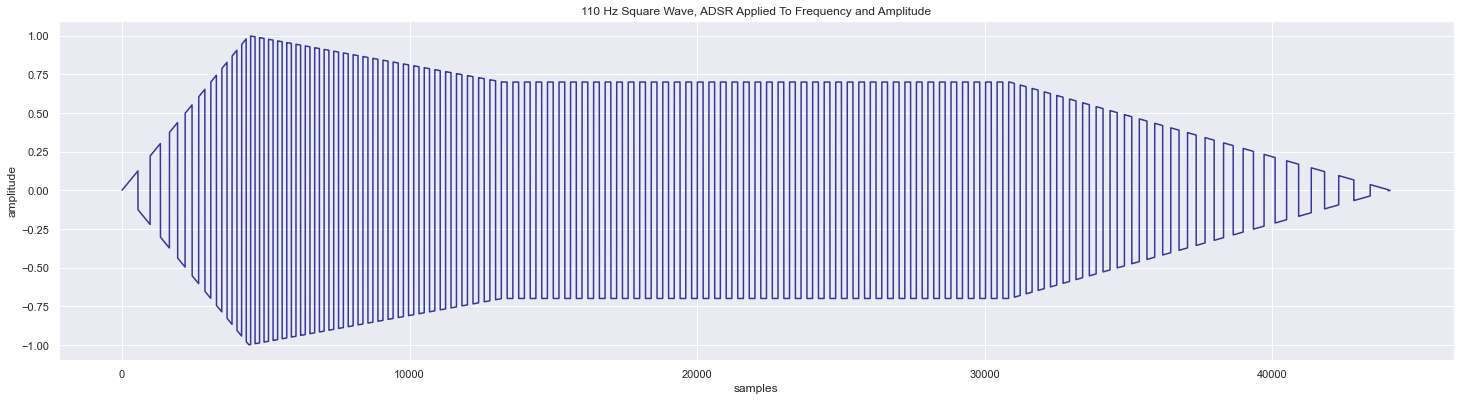

In [24]:
a,d,sl,r = 0.1, 0.2, 0.7, 0.3
sd = 0.4

def freq_mod(init_freq, env, mod_amt=0.01, sustain_level=0.7):
    return init_freq + ((env - sustain_level) * init_freq * mod_amt)

mod = ModulatedOscillator(
    SquareOscillator(110),
    ADSREnvelope(a,d,sl,r),
    amp_mod=amp_mod,
    freq_mod=lambda env, init_freq: freq_mod(env, init_freq, mod_amt=1, sustain_level=sl)
)
vals = getadsr(a,d,sl,sd,r,mod=mod)

fig = getfig()
plot(vals, title="110 Hz Square Wave, ADSR Applied To Frequency and Amplitude",\
     xlabel="samples", ylabel="amplitude", color=colors[2])
savefig(fig, "freq_amp_mod")

In [25]:
wave_to_file(vals, fname="110Hz_freq_and_amp_env")

In [26]:
ipd.Audio("./tempsnd/110Hz_freq_and_amp_env.wav")

In [27]:
class Panner:
    def __init__(self, r=0.5):
        self.r = r
        
    def __call__(self, val):
        r = self.r * 2
        l = 2 - r
        return (l * val, r * val)

In [28]:
osc = iter(SineOscillator(55))
pan = Panner(0.3)
wav = [pan(next(osc)) for i in range(44100)]

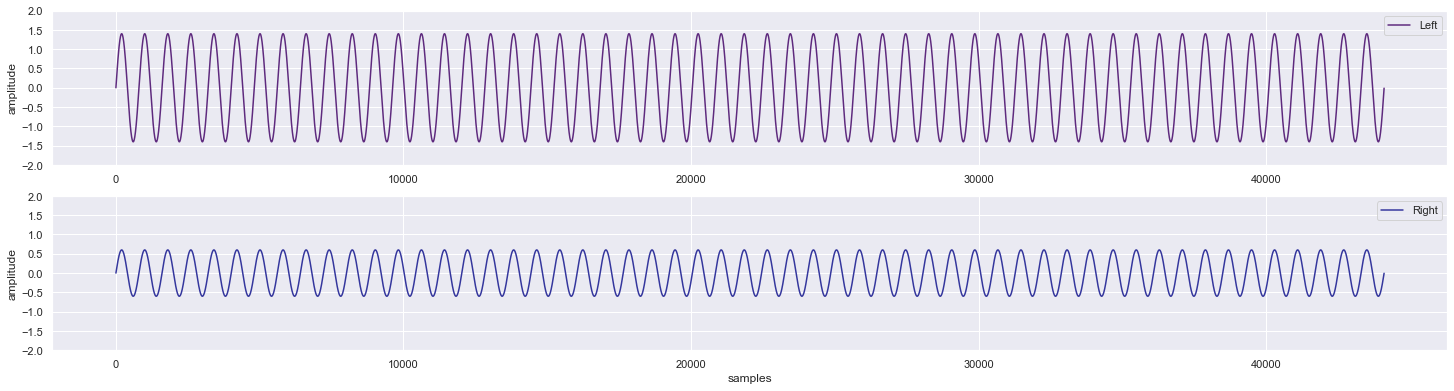

In [29]:
yticks = np.linspace(-2,2,9)
fig = getfig()
l,r = np.array(wav).T
plot(l, 2,1,1, color=colors[3], label="Left", ylabel="amplitude", yticks=yticks)
plt.legend(loc=("upper right"))

plot(r, 2,1,2, color=colors[2], label="Right", xlabel="samples", ylabel="amplitude",yticks=yticks)
plt.legend(loc=("upper right"))
savefig(fig, "panned_sine")

In [30]:
osc = iter(TriangleOscillator())
pan = Panner(); wav = []
for i in range(44):
    pan.r = i%2
    wav.extend([pan(next(osc))for i in range(4000)])
    
wave_to_file(wav, fname="panned_tri")

In [31]:
ipd.Audio("tempsnd/panned_tri.wav")

In [32]:
class Chain:
    def __init__(self, generator, *modifiers):
        self.generator = generator
        self.modifiers = modifiers
        
    def __getattr__(self, attr):
        val = None
        if hasattr(self.generator, attr):
            val = getattr(self.generator, attr)
        else:
            for modifier in self.modifiers:
                if hasattr(modifier, attr):
                    val = getattr(modifier, attr)
                    break
            else:
                raise AttributeError(f"attribute '{attr}' does not exist")
        return val
    
    def trigger_release(self):
        tr = "trigger_release"
        if hasattr(self.generator, tr):
            self.generator.trigger_release()
        for modifier in self.modifiers:
            if hasattr(modifier, tr):
                modifier.trigger_release()
                
    @property
    def ended(self):
        ended = []; e = "ended"
        if hasattr(self.generator, e):
            ended.append(self.generator.ended)
        ended.extend([m.ended for m in self.modifiers if hasattr(m, e)])
        return all(ended)
    
    def __iter__(self):
        iter(self.generator)
        [iter(mod) for mod in self.modifiers if hasattr(mod, "__iter__")]
        return self
        
    def __next__(self):
        val = next(self.generator)
        [next(mod) for mod in self.modifiers if hasattr(mod, "__iter__")]
        for modifier in self.modifiers:
            val = modifier(val)
        return val

In [33]:
from collections.abc import Iterable

class WaveAdder:
    def __init__(self, *generators, stereo=False):
        self.generators = generators
        self.stereo = stereo
        
    def _mod_channels(self, _val):
        val = _val
        if isinstance(_val, (int, float)) and self.stereo:
            val = (_val, _val)
        elif isinstance(_val, Iterable) and not self.stereo:
            val = sum(_val)/len(_val)
        return val
    
    def trigger_release(self):
        [gen.trigger_release() for gen in self.generators if hasattr(gen, "trigger_release")]
    
    @property
    def ended(self):
        ended = [gen.ended for gen in self.generators if hasattr(gen, "ended")]
        return all(ended)
    
    def __iter__(self):
        [iter(gen) for gen in self.generators]
        return self
            
    def __next__(self):
        vals = [self._mod_channels(next(gen)) for gen in self.generators]
        if self.stereo:
            l, r = zip(*vals)
            val = (sum(l)/len(l), sum(r)/len(r))
        else:
            val = sum(vals)/ len(vals)
        return val

In [34]:
gen = WaveAdder(
    ModulatedOscillator(
        SineOscillator(hz("A2")),
        ADSREnvelope(0.01, 0.1, 0.4),
        amp_mod=amp_mod
    ),
    ModulatedOscillator(
        SineOscillator(hz("A2") + 3),
        ADSREnvelope(0.01, 0.1, 0.4),
        amp_mod=amp_mod
    ),
    Chain(
        ModulatedOscillator(
            TriangleOscillator(hz("C4")),
            ADSREnvelope(0.5),
            amp_mod=amp_mod
        ),
        Panner(0.7)
    ),
    Chain(
        ModulatedOscillator(
            TriangleOscillator(hz("E3")),
            ADSREnvelope(0.5),
            amp_mod=amp_mod
        ),
        Panner(0.3)
    ),
    stereo=True
)

In [35]:
class Volume:
    def __init__(self, amp=1.):
        self.amp = amp
        
    def __call__(self, val):
        _val = None
        if isinstance(val, Iterable):
            _val = tuple(v * self.amp for v in val)
        elif isinstance(val, (int, float)):
            _val = val * self.amp
        return _val

In [36]:
class ModulatedVolume(Volume):
    def __init__(self, modulator):
        super().__init__(0.)
        self.modulator = modulator
        
    def __iter__(self):
        iter(self.modulator)
        return self
    
    def __next__(self):
        self.amp = next(self.modulator)
        return self.amp
    
    def trigger_release(self):
        if hasattr(self.modulator, "trigger_release"):
            self.modulator.trigger_release()
    
    @property
    def ended(self):
        ended = False
        if hasattr(self.modulator, "ended"):
            ended = self.modulator.ended
        return ended

In [37]:
gen = WaveAdder(
    Chain(
        WaveAdder(
            SineOscillator(hz("A2")),
            SineOscillator(hz("A2") + 3),
        ),
        ModulatedVolume(
            ADSREnvelope(0.01, 0.1, 0.4),
        )
    ),
    Chain(
        WaveAdder(
            Chain(
                TriangleOscillator(hz("C4")),
                Panner(0.7)
            ),
            Chain(
                TriangleOscillator(hz("E3")),
                Panner(0.3)
            ), stereo=True
        ),
        ModulatedVolume(
            ADSREnvelope(0.5)
        )
    ),
    stereo=True
)

In [38]:
iter(gen)
x = []
for i in range(20000):
    x.append(next(gen))

gen.trigger_release()
while not gen.ended:
    x.append(next(gen))


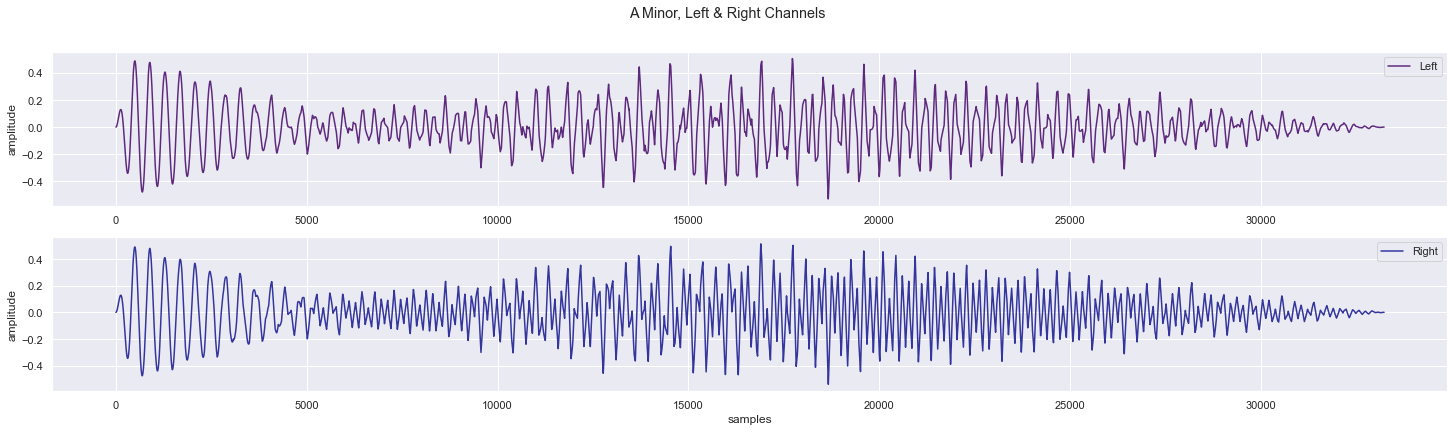

In [39]:
fig = getfig()
plt.suptitle("A Minor, Left & Right Channels")
l,r = np.array(x).T
plot(l, 2,1,1, color=colors[3], label="Left", ylabel="amplitude")
plt.legend(loc=("upper right"))

plot(r, 2,1,2, color=colors[2], label="Right", xlabel="samples", ylabel="amplitude")
plt.legend(loc=("upper right"))
savefig(fig, "a_minor_stereo")

In [40]:
wav = gettrig(gen,4)
wave_to_file(wav, fname="a_minor")
ipd.Audio("tempsnd/a_minor.wav")

## LFO

#### Amplitude Modulation

In [41]:
gen = ModulatedOscillator(
    SquareOscillator(freq=110),
    SineOscillator(freq=5, wave_range=(0.2, 1)),
    amp_mod=amp_mod
)

i = int(SR/5) * 2
s = getval(iter(gen.oscillator))[:i]
q = getval(iter(gen.modulators[0]))[:i]
g = getval(iter(gen))[:i]

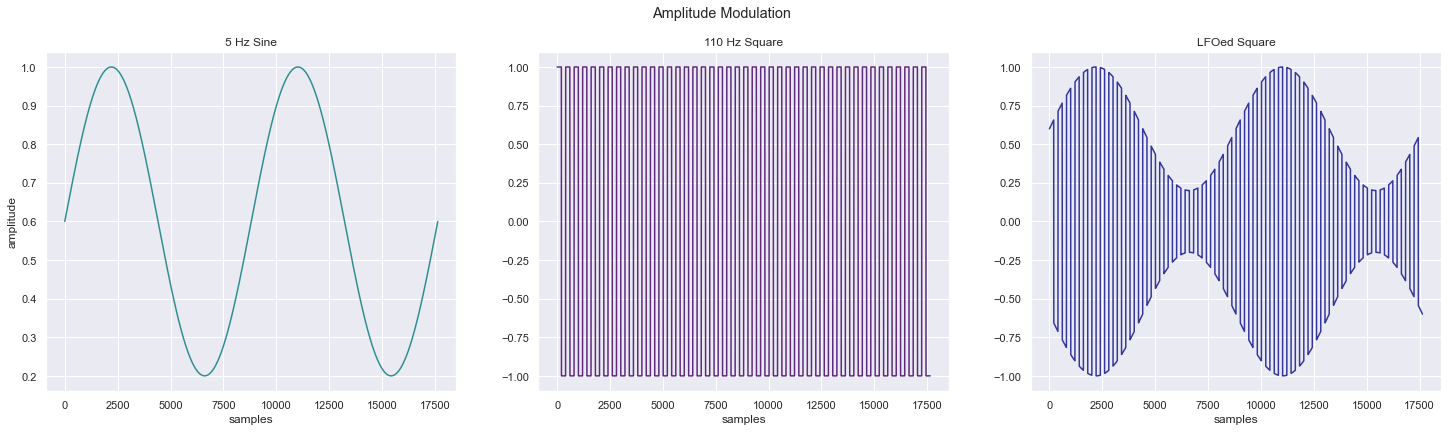

In [42]:
fig=getfig()
plt.suptitle("Amplitude Modulation")
plot(q,1,3,1, xlabel="samples", ylabel="amplitude", title="5 Hz Sine", color=colors[1])
plot(s,1,3,2, xlabel="samples", title="110 Hz Square", color=colors[3])
plot(g,1,3,3, xlabel="samples", title="LFOed Square", color=colors[2])
savefig(fig, "amp_mod")

In [43]:
wave_to_file(getval(iter(gen),SR*4), fname="am")
ipd.Audio("tempsnd/am.wav")

#### Frequency Modulation

In [44]:
def freq_mod(init_freq, val):
    return init_freq * val

In [45]:
gen = ModulatedOscillator(
    SquareOscillator(freq=110),
    SawtoothOscillator(freq=5, wave_range=(0.2, 1)),
    freq_mod=freq_mod
)

i = int(SR/5) * 2
s = getval(iter(gen.oscillator))[:i]
q = getval(iter(gen.modulators[0]))[:i]
g = getval(iter(gen))[:i]

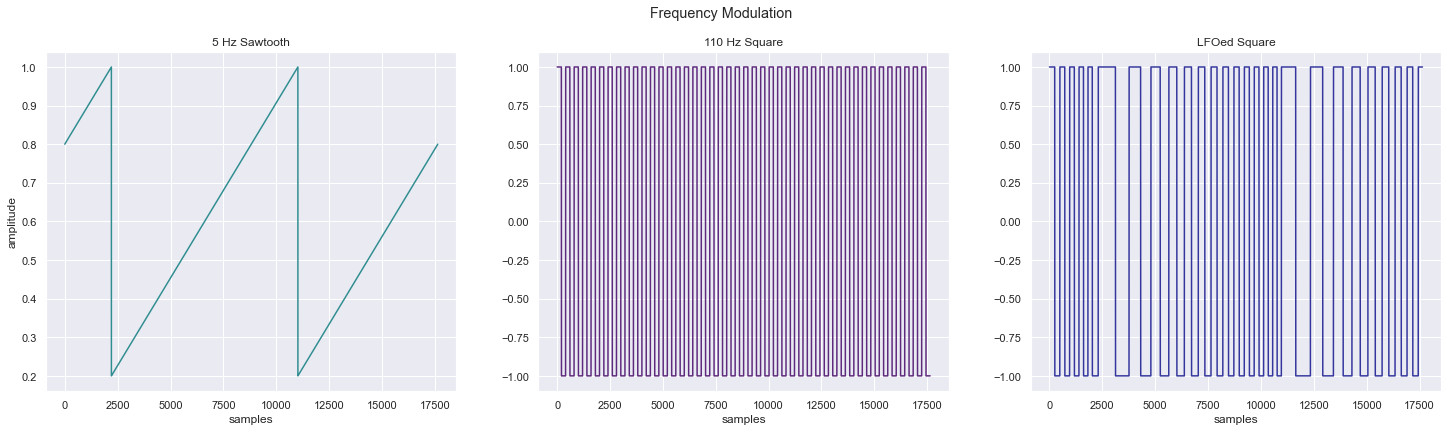

In [46]:
fig=getfig()
plt.suptitle("Frequency Modulation")
plot(q,1,3,1, xlabel="samples", ylabel="amplitude", title="5 Hz Sawtooth", color=colors[1])
plot(s,1,3,2, xlabel="samples", title="110 Hz Square", color=colors[3])
plot(g,1,3,3, xlabel="samples", title="LFOed Square", color=colors[2])
savefig(fig, "freq_mod")

In [47]:
wave_to_file(getval(iter(gen),SR*4), fname="fm")
ipd.Audio("tempsnd/fm.wav")

---

## Modulated Panner

In [48]:
class ModulatedPanner(Panner):
    def __init__(self, modulator):
        super().__init__(r=0)
        self.modulator = modulator
        
    def __iter__(self):
        iter(self.modulator)
        return self
    
    def __next__(self):
        self.r = (next(self.modulator) + 1) / 2
        return self.r

In [49]:
gen = Chain(
    SineOscillator(220),
    ModulatedPanner(
        SineOscillator(4, wave_range=(-0.8,0.8))
    )
)

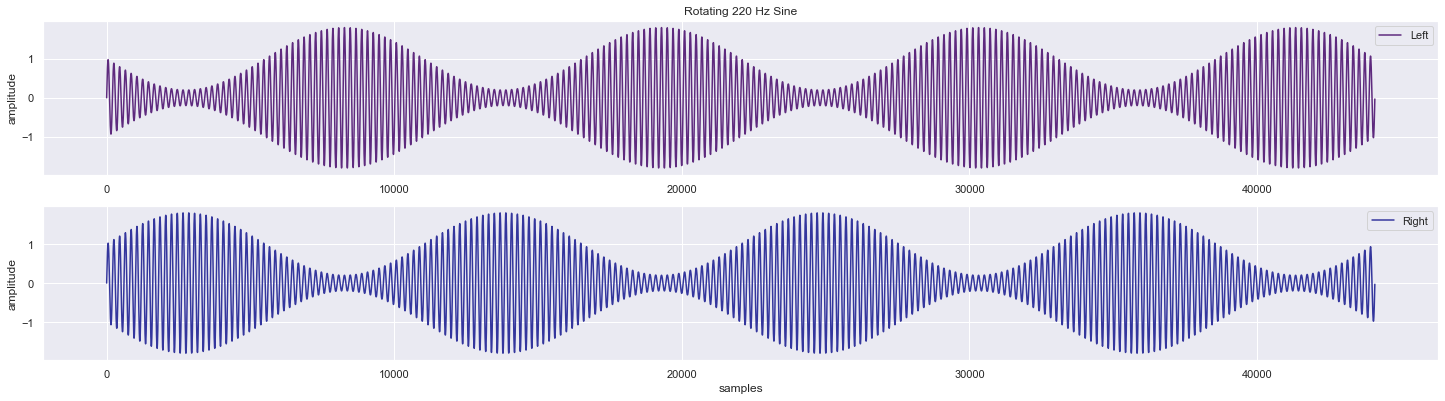

In [50]:
wav = getval(iter(gen))
fig = getfig()
l,r = np.array(wav).T

plot(l, 2,1,1, color=colors[3], label="Left", ylabel="amplitude", title="Rotating 220 Hz Sine")
plt.legend(loc=("upper right"))

plot(r, 2,1,2, color=colors[2], label="Right", xlabel="samples", ylabel="amplitude")
plt.legend(loc=("upper right"))
savefig(fig, "rot_sine")

In [51]:
wave_to_file(getval(iter(gen), int(4*SR)), fname="rot_sine")
ipd.Audio("tempsnd/rot_sine.wav")

## Examples

In [83]:
class Clipper:
    def __init__(self, wave_range=(-1,1)):
        self.mi = wave_range[0]
        self.ma = wave_range[1]
        self.mm = lambda v: max(mi, min(ma, v))
        
    def __call__(self, val):
        if isinstance(val, Iterable):
            _val = tuple(self.mm(v/2)*2 for v in val)
        else:
            _val = self.mm(val)
        return _val

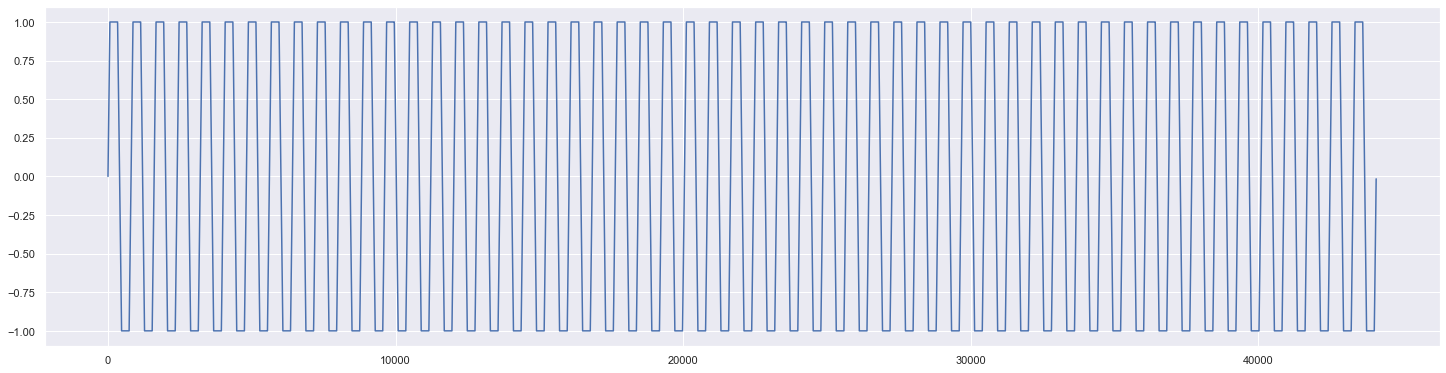

In [99]:
gen = Chain(
    SineOscillator(55, wave_range=(-2,2)),
    Clipper((-1, 1))
)

wav = getval(iter(gen), int(SR))
fig = getfig()
plot(wav)
wave_to_file(wav, fname="temp")
ipd.Audio("tempsnd/temp.wav")

In [187]:
gen = WaveAdder(
    Chain(
        SquareOscillator(hz("C5"), amp=0.3),
        ModulatedVolume(
            ADSREnvelope(attack_duration=2,decay_duration=0.001, sustain_level=1)
        ),
        ModulatedPanner(
            TriangleOscillator(1, phase=180, wave_range=(-1,1))
        )
    ),
    Chain(
        SquareOscillator(hz("A5"), amp=0.3),
        ModulatedVolume(
            ADSREnvelope(attack_duration=2,decay_duration=0.001, sustain_level=1)
        ),
        ModulatedPanner(
            TriangleOscillator(1, wave_range=(-1,1))
        )
    ),
    Chain(
        ModulatedOscillator(
            SawtoothOscillator(hz("A4"),amp=0.8),
            SineOscillator(10, wave_range=(0.9,1)),
            freq_mod=amp_mod
        ),
        ModulatedVolume(
            ADSREnvelope(1)
        ),
        Panner(0.3)
    ),
    Chain(
        ModulatedOscillator(
            SawtoothOscillator(hz("C4"),amp=0.8),
            SineOscillator(10, wave_range=(0.9,1)),
            freq_mod=amp_mod
        ),
        ModulatedVolume(
            ADSREnvelope(1)
        ),
        Panner(0.7)
    ),
    SineOscillator(hz("C3")),
    stereo=True
)

wav = getval(iter(gen), int(SR*4))
# fig = getfig()
# plot(wav)
wave_to_file(wav, fname="prelude")
ipd.Audio("tempsnd/prelude.wav")

In [52]:
gen = WaveAdder(
    Chain(
        TriangleOscillator(hz("C4")),
        ModulatedPanner(
            SineOscillator(3, wave_range=(-1,1))
        ),
    ),
    Chain(
        SineOscillator(hz("E4")),
        ModulatedPanner(
            SineOscillator(2, wave_range=(-1,1))
        ),
    ),
    Chain(
        TriangleOscillator(hz("G4")),
        ModulatedPanner(
            SineOscillator(3, phase=180, wave_range=(-1,1))
        ),
    ),
    Chain(
        SineOscillator(hz("B4")),
        ModulatedPanner(
            SineOscillator(2, phase=180, wave_range=(-1,1))
        ),
    ),
    stereo=True
)

In [53]:
wav = getval(iter(gen), int(4*SR))
wave_to_file(wav, fname="rot_cmaj")
ipd.Audio("tempsnd/rot_cmaj.wav")

In [206]:
gen = Chain(
    WaveAdder(
        Chain(
            ModulatedOscillator(
                SineOscillator(hz("A4")),
                ModulatedOscillator(
                    SineOscillator(20),
                    ADSREnvelope(0,4,0),
                    freq_mod=amp_mod
                ),
                freq_mod=freq_mod
            ),
            Panner(0)
        ),
        Chain(
            ModulatedOscillator(
                SineOscillator(hz("A4")),
                ModulatedOscillator(
                    SineOscillator(20),
                    ADSREnvelope(4),
                    freq_mod=amp_mod
                ),
                freq_mod=freq_mod
            ),
            Panner(1)
        ),
        stereo=True
    )
)
wav = getval(iter(gen), int(SR*4))
wave_to_file(wav, fname="accel_decel")
ipd.Audio("tempsnd/accel_decel.wav")